# AmBe Data
The AmBe data was taken with the 9Li trigger. We launch 1820 readout windows, each of them 270 $\mu s$ long with 7 $\mu s$ between them, after those 1820
windows, we wait 20 (or whatever) seconds, and then another burst of 1820 windows.

7 $\mu s$ = 7e3 ns\
20 s       = 2e10 ns = 2e7 $\mu s$


In [ ]:
import sys
import os

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/Users/diiego/Library/Mobile Documents/com~apple~CloudDocs/Desktop/DIEGO_cloud/USC/PHD/HK/HK SOURCES/code/ambe_source/WCTE_BRB_Data_Analysis"))
sys.path.append(os.path.abspath("/Users/diiego/Library/Mobile Documents/com~apple~CloudDocs/Desktop/DIEGO_cloud/USC/PHD/HK/HK SOURCES/code/ambe_source/nHits_trigger"))
sys.path.append('/Users/diiego/software/hipy')
# sys.path.append("/eos/home-d/dcostasr/SWAN_projects/software/wcte_software/")

import hipy.pltext       as pltext
import hipy.utils        as ut
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np
import matplotlib.colors as colors

from src.read_data         import load_concatenated, read_parquet, nHits, read_mpmt_offsets
from tqdm                  import tqdm
from WCTE_event_display.EventDisplay import EventDisplay
from scipy.special import factorial


%load_ext autoreload
%autoreload 2

pltext.style()

## Read Data

In [3]:
# ============= LOADS THE DATA ===================
bkg_run  = 2384
bkg_data = load_concatenated(outdir=f"/Users/diiego/Library/Mobile Documents/com~apple~CloudDocs/Desktop/DIEGO_cloud/USC/PHD/HK/HK SOURCES/code/ambe_source/AmBe_Data_Analysis/data/{bkg_run}_calibrated_tof")
print("Data Loaded")

# =============== MASK OUT CARDS 130-132 ===================
bkg_run_cards, bkg_run_channels, bkg_run_slots, bkg_run_positions, bkg_run_times, bkg_run_events, bkg_run_charges, bkg_run_window_times = read_parquet(bkg_data, mask=True)
print("Data Masked")

bkg_run_times_sorted = ak.sort(bkg_run_times) - bkg_run_window_times
bkg_run_window_times_sorted = ak.sort(bkg_run_window_times, axis=0)

Data Loaded
Data Masked


## Check That Data Makes Sense. I.E.: Separation between bunches is 20 s and separation between windows is 7 $\mu s$

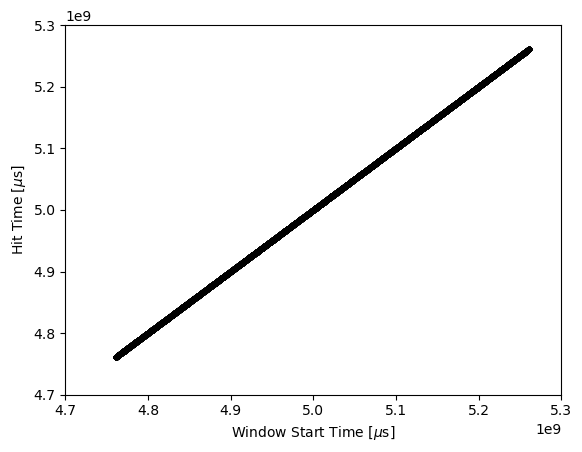

In [16]:
plt.scatter(ak.ravel(run_window_times)[::100], ak.ravel(run_times)[::100], marker=".");
plt.ylabel("Hit Time [$\mu$s]");
plt.xlabel("Window Start Time [$\mu$s]");

# plt.vlines(ak.sort(run_window_times)[0][0], 0, 6e10);
# plt.vlines(run_window_times[0][0]+2e10, 0, 6e10);
# plt.vlines(run_window_times[0][0]+4e10, 0, 6e10);

plt.xlim(0.47e10, 0.53e10);
plt.ylim(0.47e10, 0.53e10);

Time Between Windows 277.752
Lenght Of the Window 173.7147577724457


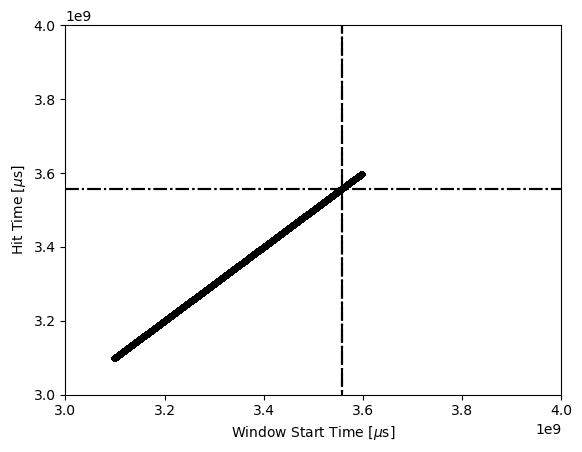

In [ ]:
plt.scatter(ak.ravel(run_window_times), ak.ravel(run_times), marker=".");
plt.ylabel("Hit Time [$\mu$s]");
plt.xlabel("Window Start Time [$\mu$s]");

plt.vlines(ak.sort(run_window_times)[0][0], 0, 6e10, linestyle="-.");
plt.vlines(ak.sort(run_window_times)[0][0]+2.7e5, 0, 6e10, linestyle="-.");
plt.vlines(ak.sort(run_window_times)[0][0]+2.7e5+7e3, 0, 6e10, linestyle="--");

plt.hlines(ak.sort(run_times)[0][0], 0, 6e10, linestyle="-.");
plt.hlines(ak.sort(run_times)[0][0]+2.7e5, 0, 6e10, linestyle="-.");

# plt.xlim(0.309805e10, 0.30985e10);
# plt.ylim(0.30980e10, 0.309875e10);

plt.xlim(0.3e10, 0.4e10);
plt.ylim(0.3e10, 0.4e10);

print("Time Between Windows", (run_window_times[1][0] - run_window_times[0][0])*1e-3)
print("Lenght Of the Window", (run_times[0][-1] - run_times[0][0])*1e-3)

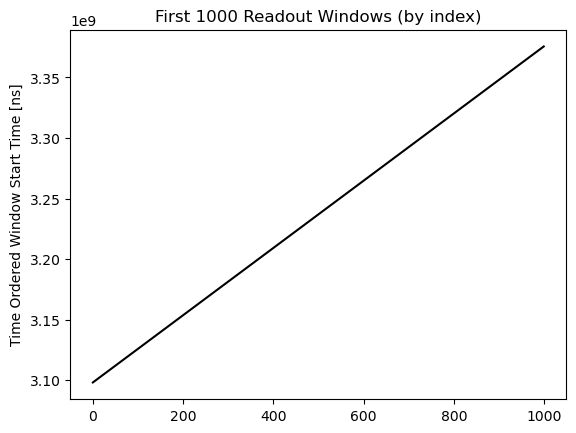

In [ ]:
plt.plot(run_window_times_sorted[:,0][:1000]);
plt.ylabel("Time Ordered Window Start Time [ns]");
plt.title("First 1000 Readout Windows (by index)");

## Looking At Readout Windows

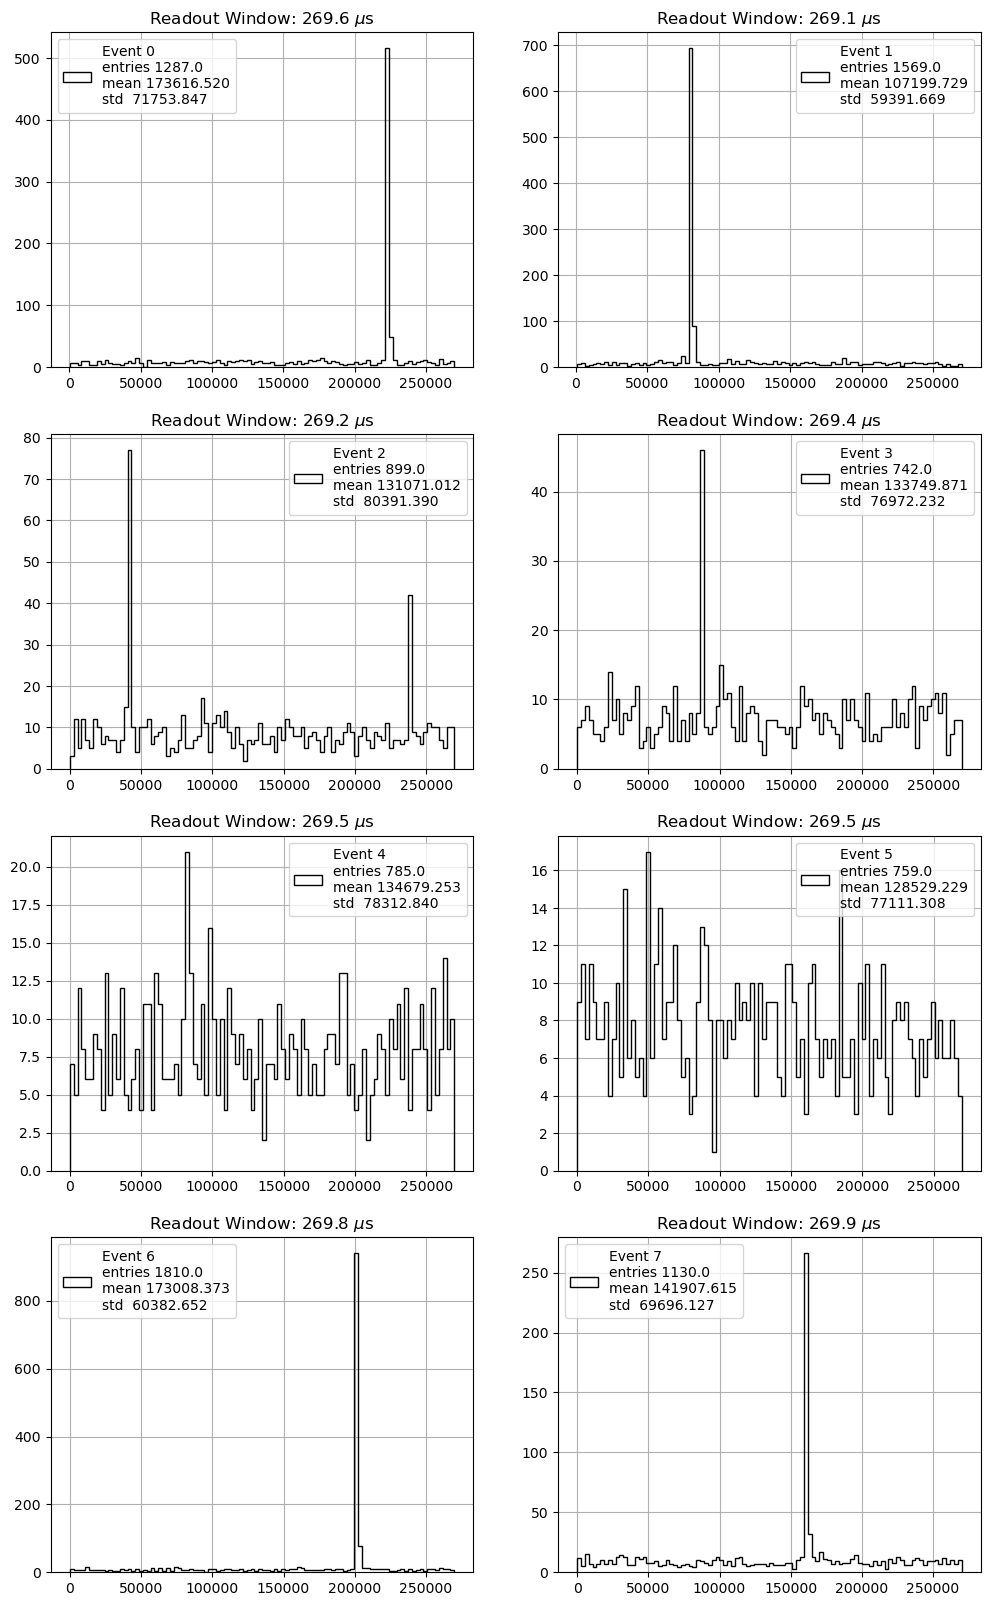

In [ ]:
subplot = pltext.canvas(8)

for i,event in enumerate(range(8)):
    subplot(i+1)
    pltext.hist(run_times_sorted[event], 100, label=f"Event {event}");
    plt.title(f"Readout Window: {(run_times_sorted[event][-1] - run_times_sorted[event][0])*1e-3:.1f} $\mu$s")

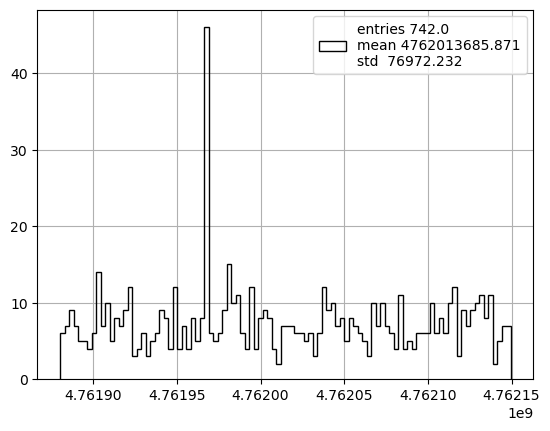

In [ ]:
data = run_times[3]
hist_range=(3.557e9+577000, 3.557e9+578500)
indices_in_range = np.where((data >= hist_range[0]) & (data <= hist_range[1]))[0]

pltext.hist(data, 100, range=None);
# plt.title(f"Window Lenght: {data[indices_in_range][-1] - data[indices_in_range][0]:.2f} ns. {len(data[indices_in_range])} Hits");

### Event Display

(2014,)


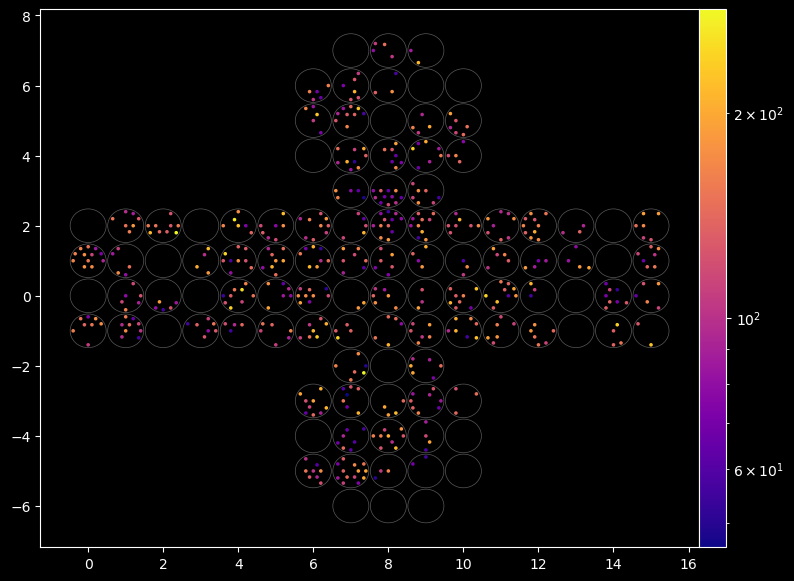

In [ ]:
event = 5
pmt_id = (run_slots[event]*19 + run_positions[event])
data_to_plot = run_charges[event]#[indices_in_range]

eventDisplay = EventDisplay() 
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')

ev_disp_data = eventDisplay.process_data(pmt_id, data_to_plot, sum_data=False)
eventDisplay.plotEventDisplay(ev_disp_data, color_norm=colors.LogNorm(), style="dark_background", fig_width=10)

plt.show(block=False)
plt.style.use('default');

pltext.style()

# nHits To Find Spills and AfterPulsing

In [72]:
bkg__triggered_spill_hits_index, bkg__triggered_spill_hit_times = nHits(mode="multiple_events", hit_times=bkg_run_times_sorted,  w=5000, thresh_min=200, thresh_max=10000, pre_window=0, post_window=4000, jump=9000)

100%|██████████| 25315/25315 [00:07<00:00, 3316.50it/s]


### Produce nHits_Spills.pdf With Event Display Too

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from itertools import islice

with PdfPages("./bkg_nHits_Spills_Hist.pdf") as pdf:
    for key, value in tqdm(islice(bkg__triggered_spill_hits_index.items(), 100), total=100):
        
        event = key
        data = bkg_run_times_sorted[event]
        pltext.hist(data                                                            , 100, range=(data[0], data[-1]), label=f"Event {event}");
        pltext.hist(data[np.concatenate(bkg__triggered_spill_hits_index.get(event))], 100, range=(data[0], data[-1]), label="Triggered Hits");
        
        plt.title(f"Readout Window: {(data[-1] - data[0])*1e-3:.1f} $\mu$s")

        pdf.savefig()  
        plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

### Remove Spills from data

In [ ]:
def remove_spill(trigger_indices, run_times):
    corrected_run_times = []

    for i in tqdm(range(len(run_times))):
        if i in trigger_indices:
            # Evento con spill → eliminar los índices indicados
            data = run_times[i]
            trigger_indices_event = np.concatenate(trigger_indices[i])
            all_indices           = np.arange(len(data))
            valid_indices         = np.setdiff1d(all_indices, trigger_indices_event)
            corrected_run_times.append(data[valid_indices])
        else:
            # Evento sin spill → dejar tal cual
            corrected_run_times.append(run_times[i])

    return ak.Array(corrected_run_times)

In [73]:
bkg__corrected_run_times_sorted = remove_spill(bkg__triggered_spill_hits_index, bkg_run_times_sorted)

100%|██████████| 25315/25315 [00:03<00:00, 6618.38it/s]


In [7]:
bkg__corrected_run_charge = remove_spill(bkg__triggered_spill_hits_index,  bkg_run_charges)

100%|██████████| 8121/8121 [00:02<00:00, 3980.10it/s]


# Looking At Readout Windows Without Spills

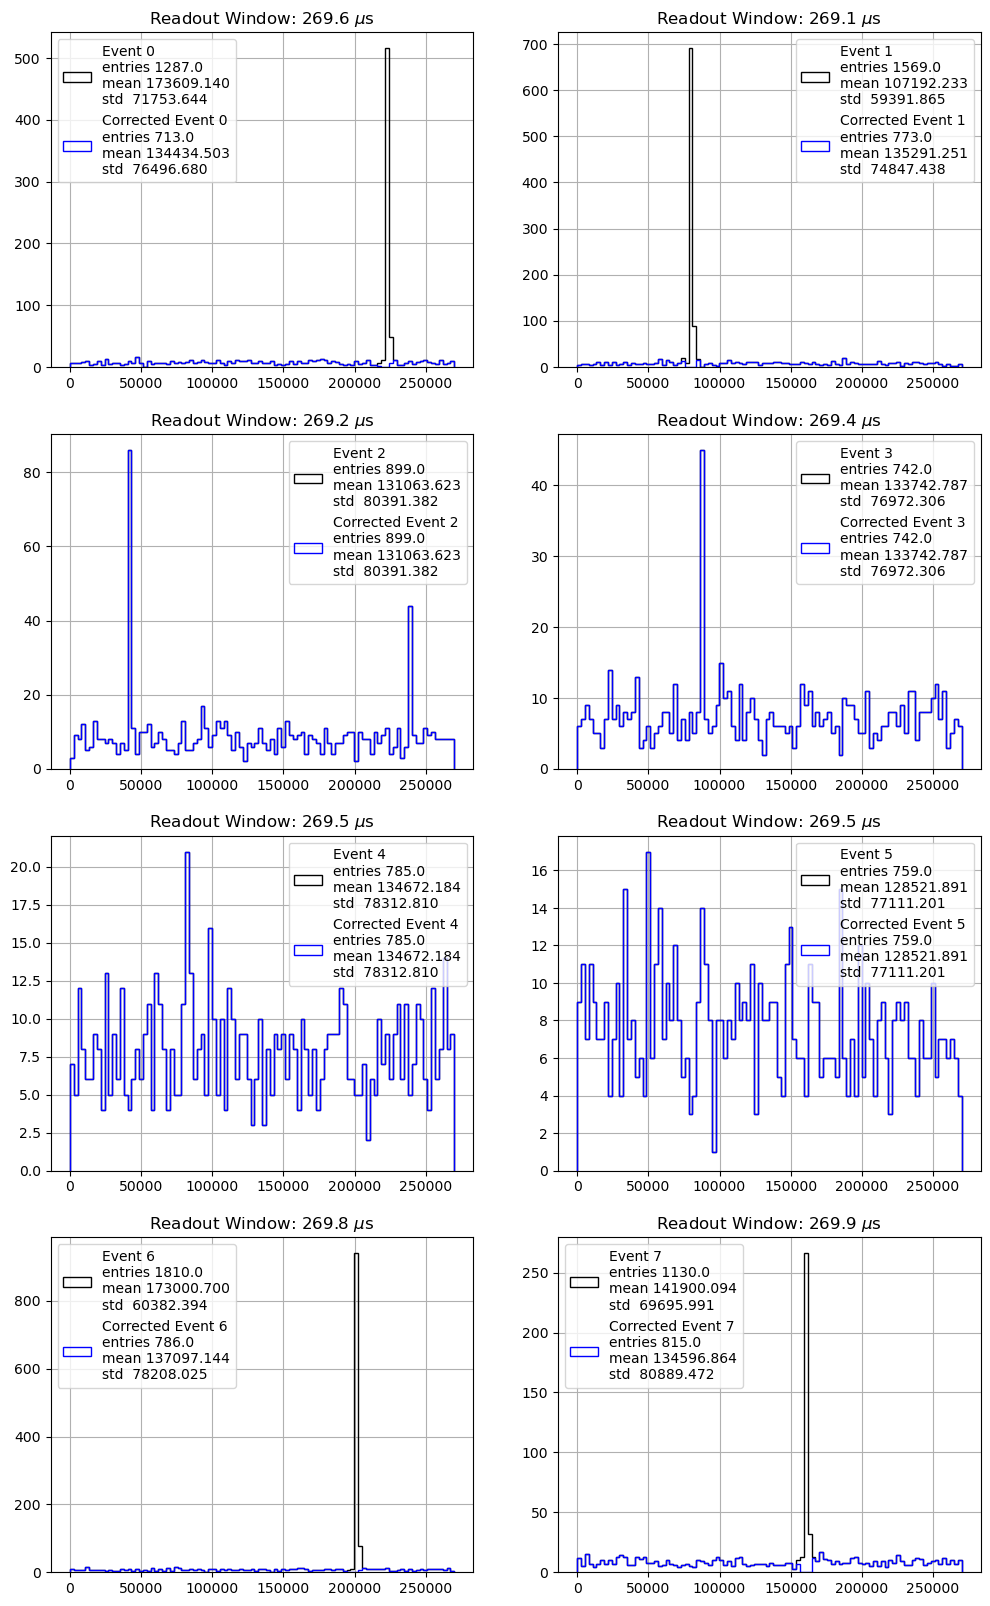

In [74]:
subplot = pltext.canvas(8)

for i,event in enumerate(range(8)):
    subplot(i+1)
    pltext.hist(bkg_run_times_sorted[event],            100, range=(0, 270e3), label=f"Event {event}");
    pltext.hist(bkg__corrected_run_times_sorted[event], 100, range=(0, 270e3), label=f"Corrected Event {event}");
    plt.title(f"Readout Window: {(bkg__corrected_run_times_sorted[event][-1] - bkg__corrected_run_times_sorted[event][0])*1e-3:.1f} $\mu$s")

### Event Display

(2014,)


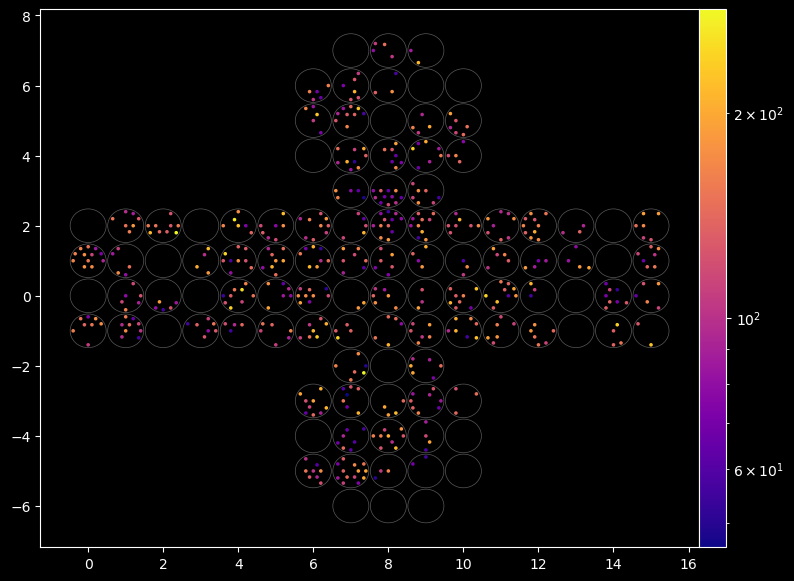

In [ ]:
event = 5
pmt_id = (bkg_run_slots[event]*19 + bkg_run_positions[event])
data_to_plot = bkg_run_charges[event]#[indices_in_range]

eventDisplay = EventDisplay() 
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')

ev_disp_data = eventDisplay.process_data(pmt_id, data_to_plot, sum_data=False)
eventDisplay.plotEventDisplay(ev_disp_data, color_norm=colors.LogNorm(), style="dark_background", fig_width=10)

plt.show(block=False)
plt.style.use('default');

pltext.style()